<a href="https://colab.research.google.com/github/pabloswfly/Genomcmcgan/blob/master/genogan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that we have learn to do demographic simulations with msprime, we can start building our discriminator with the permutation invariance property. The discriminator in the beginning will tell apart simulations with a difference in a single parameter, such as mutation rate, recombination rate, effective size, etc.

In [ ]:
%%capture
# Installing required libraries
!apt-get install python-dev libgsl0-dev
!python3 -m pip install msprime stdpopsim
!pip install tskit==0.2.3 zarr

In [ ]:
# Importing libraries and modules
import msprime, stdpopsim, zarr, random, imageio, bisect
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Mount my Gdrive disk
from google.colab import drive, files
drive.mount('/content/gdrive')
!mkdir /content/results

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘/content/results’: File exists


In [ ]:
 class Genobuilder():
    """Class for building genotype matrices from msprime, stdpopsim
      or empirical data read from Zarr directories, and other utilities
      relates to these"""

    def __init__(self, source, num_samples, seq_len, maf_thresh,
                 fixed_dim = 128, scale=False, **kwargs):
      self._num_samples = num_samples
      self._seq_len = seq_len
      self._maf_thresh = maf_thresh
      self._source = source
      self._fixed_dim = fixed_dim
      self._scale = scale
      self._param_bounds = None
      self._num_reps = None
      super(Genobuilder, self).__init__(**kwargs)

    
    def set_parameters(self, sim_source, param_name, fixed_val, 
                       param_bounds, log_scale):
      
      self._sim_source = sim_source
      self._param_name = param_name
      self._param_bounds = param_bounds
      self._log_scale = log_scale
      if log_scale:
        # float_power allows to use negative numbers as exponent
        self._fixed_val = np.float_power(10, fixed_val)
      else:
        self._fixed_val = fixed_val


    @property
    def num_samples(self):
      return self._num_samples

    @property
    def seq_len(self):
      return self._seq_len

    @property
    def maf_thresh(self):
      return self._maf_thresh

    @property
    def source(self):
      return self._source

    @property
    def fixed_dim(self):
      return self._fixed_dim

    @property
    def num_reps(self):
      return self._num_reps

    @property
    def fixed_val(self):
      return self._fixed_val

    @property
    def param_bounds(self):
      return self._param_bounds

    @property
    def sim_source(self):
      return self._sim_source

    @property
    def param_name(self):
      return self._param_name

    @property
    def log_scale(self):
      return self._log_scale

    @property
    def scale(self):
      return self._scale


    @num_samples.setter
    def num_samples(self, n):
      if type(n) != int or n < 0:
        raise ValueError('Genobuilder num_samples must be a positive integer')
      self._num_samples = n

    @maf_thresh.setter
    def maf_thresh(self, maf):
      if maf < 0 or maf > 1:
        raise ValueError('The Minor Allele Frequency must be between 0 and 1')
      self._maf_thresh = maf

    @seq_len.setter
    def seq_len(self, l):
      self._seq_len = int(l)  

    @source.setter
    def source(self, s):
      if s not in ['msprime', 'stdpopsim', 'empirical']:
        raise ValueError('Genobuilder source must be either msprime, '
                         'stdpopsim or empirical')
      self._source = s

    @fixed_dim.setter
    def fixed_dim(self, f):
      if f % 2 != 0:
        raise ValueError('We recommend the fixed dimension to be multiple of 2')
      self._fixed_dim = f

    @num_reps.setter
    def num_reps(self, n):
      self._num_reps = n

    @fixed_val.setter
    def fixed_val(self, v):
      if self._log_scale:
        self._fixed_val = np.float_power(10, v)
      else:
        self._fixed_val = v 

    @param_bounds.setter
    def param_bounds(self, b):
      if type(b) is not tuple:
        raise ValueError('We recommend the fixed dimension to be multiple of 2')
      self._param_bounds = b

    @sim_source.setter
    def sim_source(self, s):
      if s not in ['msprime', 'stdpopsim']:
        raise ValueError('Genobuilder sim_source must be either', 
                         'msprime or stdpopsim')
      self._sim_source = s 

    @param_name.setter
    def param_name(self, n):
      if n not in ['recomb', 'mutation', 'effective', 'growth']:
        raise ValueError('Genobuilder param_name must be either', 
                         'recomb, mutation, effective or growth')
      self._param_name = n 

    @log_scale.setter
    def log_scale(self, l):
      if type(l) is not bool:
        raise ValueError('log_scale must be either True or False')
      self._log_scale = l 



    def simulate_msprime(self, x=None, seed=None):
      """Simulate demographic data, returning a tensor with n_reps number 
      of genotype matrices"""

      if x == None:
        x = self.fixed_val

      if self.param_name=='recomb':
        sims = msprime.simulate(
            sample_size=self.num_samples, Ne=10000, length=self.seq_len, 
            mutation_rate=1e-8, recombination_rate=x, 
            num_replicates=self.num_reps, random_seed=seed)
        
      elif self.param_name=='mutation':
        sims = msprime.simulate(
            sample_size=self.num_samples, Ne=10000, length=self.seq_len, 
            mutation_rate=self.fixed_val, recombination_rate=1e-8, 
            num_replicates=self.num_reps, random_seed=seed)
        
      elif self.param_name=='effective':
        sims = msprime.simulate(
            sample_size=self.num_samples, Ne=self.fixed_val, 
            length=self.seq_len, mutation_rate=1e-8, recombination_rate=1e-8, 
            num_replicates=self.num_reps, random_seed=seed)
        
      elif self.param_name=='growth':
        popconfig = msprime.PopulationConfiguration(
            sample_size=self._num_samples, growth_rate=self.fixed_val)
        sims = msprime.simulate(
            Ne=10000, length=self.seq_len, mutation_rate=1e-8, 
            recombination_rate=1e-8, num_replicates=self.num_reps, 
            random_seed=seed, population_configurations=popconfig)

      mat = np.zeros((self.num_reps, self.num_samples, self.fixed_dim))

      # For each tree sequence output from the simulation
      for i, ts in enumerate(sims):
        mat[i] = self._resize_from_ts(ts)

      # Scale genotype matrices from [0, 1] to [-1, 1]. If we were to use 
      # a generator, this scale should be done with tanh function
      if self.scale:
        mat = scale_matrix(mat)

      # Expand dimension by 1 (add channel dim). -1 stands for last axis.
      mat = np.expand_dims(mat, axis=-1)

      return mat



    def _simulate_msprime_list(self, param_vals, seed=None):
      """Simulate demographic data, returning a tensor with n_reps number of 
      genotype matrices. Here, params is a list of values, not a single scalar"""

      sims = []

      if self.param_name=='recomb':
        for p in param_vals:
          sims.append(msprime.simulate(
              sample_size=self.num_samples, Ne=10000, length=self.seq_len, 
              mutation_rate=1e-8, recombination_rate=p, random_seed=seed))
        
      elif self.param_name=='mutation':
        for p in param_vals:
          sims.append(msprime.simulate(
              sample_size=self.num_samples, Ne=10000, length=self.seq_len, 
              mutation_rate=p, recombination_rate=1e-8, random_seed=seed))
      
      elif self.param_name=='effective':
        for p in param_vals:
          sims.append(msprime.simulate(
              sample_size=self.num_samples, Ne=p, length=self.seq_len, 
              mutation_rate=1e-8, recombination_rate=1e-8, random_seed=seed))
          
      elif self.param_name=='growth':
        for p in param_vals:
          popconfig = msprime.PopulationConfiguration(
              sample_size=self.num_samples, growth_rate=p)
          sims = msprime.simulate(
              Ne=10000, length=self.seq_len, mutation_rate=1e-8, 
              recombination_rate=1e-8, random_seed=seed, 
              population_configurations=popconfig)


      mat = np.zeros((self.num_reps, self.num_samples, self.fixed_dim))

      # For each tree sequence output from the simulation
      for i, ts in enumerate(sims):
        mat[i] = self._resize_from_ts(ts)

      # Scale genotype matrices from [0, 1] to [-1, 1]. If we were to use 
      # a generator, this scale should be done with tanh function
      if self.scale:
        mat = scale_matrix(mat)

      # Expand dimension by 1 (add channel dim). -1 stands for last axis.
      mat = np.expand_dims(mat, axis=-1)

      return mat



    def _parse_empiricaldata(self, haplotype):

      # Set up some data paths
      mask_file = "/content/gdrive/My Drive/mcmcgan/20140520.pilot_mask.autosomes.bed"
      zarr_path = "/content/gdrive/My Drive/mcmcgan/zarr"

      # Locate the data contained in zarr
      callset = zarr.open_group(zarr_path, mode='r')

      num_samples = len(callset['1/samples'])

      l = []

      data = np.zeros((self.num_reps, num_samples, self.fixed_dim))

      # Get lists of randomly selected chromosomes and genomic locations
      chroms, pos, slices = self._random_sampling_geno(
          callset, mask_file=mask_file)

      # For each randomly sampled genomic location
      for i, (chrom, pos, loc_region) in enumerate(zip(chroms, pos, slices)):
        print(f'it {i}  :  chromosome {chrom}  :  position {pos}')

        # Extract genotype and genomic position for the variants for all samples
        gt_zarr = np.asarray(callset[f'{chrom}/calldata/GT'][loc_region])
        pos_zarr = callset[f'{chrom}/variants/POS'][loc_region]

        # Make sure the genome is diploid, and extract one of the haplotypes
        assert gt_zarr.shape[2] is 2, "Samples are not diploid"
        hap = self._haploidify(gt_zarr, haplotype)

        # To check the number of 0s and 1s in each gt
        # Filtering missing data by looking at -1? No -1 in 1000 genomes data.
        #unique, counts = np.unique(hap, return_counts=True)
        #print(dict(zip(unique, counts)))

        # Get the relative position in the sequence length to resize the matrix
        relative_pos = pos_zarr - pos

        if self.maf_thresh is not None:
          hap, relative_pos = filter_maf(hap, relative_pos, self.maf_thresh)
          l.append(hap.shape[0])

        data[i] = self._resize(hap, relative_pos)

      if self.scale:
        data = scale_matrix(data)

      data = np.expand_dims(data, axis=-1)

      print(len(l))
      print(np.mean(l))
      print(np.std(l))
      
      return data


    def simulate_stdpopsim(self, engine, species, model, pop, 
                            error_prob=None, seed=None):

      stdengine = stdpopsim.get_engine(engine)
      stdspecies = stdpopsim.get_species(species)
      stdmodel = stdspecies.get_demographic_model(model)

      geno = [(i, get_chrom_size(i)) for i in range(1, 23)]
      # Sort the list by size.
      geno.sort(key=lambda a: a[1], reverse=True)
      cum_weights = []
      rng = random.Random(seed)
      for i, (chrom, size) in enumerate(geno):
          cum_weights.append(size if i == 0 else size + cum_weights[i-1])

      # The order for sampling from populations is ['YRI', 'CEU', 'CHB']
      if pop=='YRI':
        stdsamples = stdmodel.get_samples(self.num_samples, 0, 0)
      elif pop=='CEU':
        stdsamples = stdmodel.get_samples(0, self.num_samples, 0)
      elif pop=='CHB':
        stdsamples = stdmodel.get_samples(0, 0, self.num_samples)

      sims = []
      for i in range(self.num_reps):
        chrom, size = rng.choices(geno, cum_weights=cum_weights)[0]
        factor = self.seq_len/size
        stdcontig = stdspecies.get_contig(
            'chr' + str(chrom), length_multiplier=factor)
        sims.append(stdengine.simulate(stdmodel, stdcontig, stdsamples))

      mat = np.zeros((self.num_reps, self.num_samples, self.fixed_dim))

      # For each tree sequence output from the simulation
      for i, ts in enumerate(sims):

        if type(error_prob) is float:
          mat[i] = self._mutate_geno(ts, p=error_prob)

        elif type(error_prob) is np.ndarray:
          mat[i] = self._mutate_geno(ts, p=error_prob[i])

        # No error prob, it doesn't mutate the matrix
        else:
          mat[i] = self._resize_from_ts(ts)
          

      # Scale genotype matrices from [0, 1] to [-1, 1]. If we were to use 
      # a generator, this scale should be done with tanh function
      if self.scale:
        mat = scale_matrix(mat)

      # Expand dimension by 1 (add channel dim). -1 stands for last axis.
      mat = np.expand_dims(mat, axis=-1)

      return mat



    def generate_data(self, num_reps, paramlist=None):
      #Generate (X, y) data from demographic simulations.

      self.num_reps = num_reps
      low, high = self.param_bounds

      print(f'generating {num_reps} genotype matrices from {self.source}')
      if self.source=='stdpopsim':
        gen1 = self.simulate_stdpopsim(engine='msprime', species='HomSap', 
                            model='OutOfAfricaArchaicAdmixture_5R19', pop='CEU',
                            error_prob=None)
        
      elif self.source=='empirical':
        gen1 = self._parse_empiricaldata(haplotype = 0)

      elif self.source=='msprime':
        gen1 = self.simulate_msprime(seed=None)
    
      return gen1


    def generate_testdata(self, num_reps, testlist=None):

      self.num_reps = num_reps
      low, high = self.param_bounds

      print(f'generating {num_reps} genotype matrices with different'
            f' {self.param_name} from {self.sim_source} for testing')
      
      if type(testlist) is not np.ndarray:
          if self.log_scale:  
            exps = np.linspace(low, high, num=num_reps)
            testlist = np.float_power(10, exps)
          else:
            testlist = np.linspace(low, high, num=num_reps)

      if self.sim_source=='msprime':
        x_test = self._simulate_msprime_list(testlist, seed=None)
      if self.sim_source=='stdpopsim':
        x_test = self.simulate_stdpopsim(engine='msprime', species='HomSap', 
                            model='OutOfAfricaArchaicAdmixture_5R19', 
                            pop='CEU', error_prob=testlist, seed=None)

      return x_test, testlist


    def generator_iterator(self, num_reps):

      self.num_reps = num_reps

      print(f'generating {num_reps} genotype matrices with different'
            f' {self.param_name} from {self.sim_source} for testing')
      
      if self.sim_source=='msprime':
        x = self.simulate_msprime(seed=None)
      if self.sim_source=='stdpopsim':
        x = self.simulate_stdpopsim(engine='msprime', species='HomSap', 
                            model='OutOfAfricaArchaicAdmixture_5R19', 
                            pop='CEU', error_prob=p_val, seed=None)

      yield x
      


    def _mutate_geno_old(self, ts, p=0.001):
      """Returns a genotype matrix with a fixed number of columns, 
      as specified in x"""

      rows = int(self.num_samples)
      cols = int(self.seq_len)
      m = np.zeros((rows, cols), dtype=float)

      for variant in ts.variants():

          # Filter by MAF
          if self.maf_thresh is not None:
              af = np.mean(variant.genotypes)
              if af < self.maf_thresh or af > 1 - self.maf_thresh:
                  continue

          m[:, int(variant.site.position)] += variant.genotypes

      m = m.flatten()
      n = np.random.binomial(len(m), p)
      idx = np.random.randint(0, len(m), size=n)
      m[idx] = 1 - m[idx]
      m = m.reshape((rows, cols))

      f = int(cols/self.fixed_dim)
      mat = np.zeros((rows, self.fixed_dim), dtype=float)

      for i in range(self.fixed_dim):
        s = i*f
        e = s + f - 1
        mat[:, i] = np.sum(m[:, s:e], axis=1)

      return mat


    def _mutate_geno(self, ts, p=0.001):
      """Returns a genotype matrix with a fixed number of columns, 
      as specified in x"""

      rows = int(self.num_samples)
      cols = int(self.fixed_dim)
      m = np.zeros((rows, cols), dtype=float)

      for variant in ts.variants():

          # Filter by MAF
          if self.maf_thresh is not None:
              af = np.mean(variant.genotypes)
              if af < self.maf_thresh or af > 1 - self.maf_thresh:
                  continue


          n = np.random.binomial(len(variant.genotypes), p)
          if n is not None:
              idx = np.random.randint(0, len(variant.genotypes), size=n)
              variant.genotypes[idx] = 1 - variant.genotypes[idx]

          j = int(variant.site.position * self.fixed_dim / ts.sequence_length)
          m[:, j] += variant.genotypes


      return m



    def _random_sampling_geno(self, callset, mask_file = None, seed = None):
      """random sampling from chromosome based on the proportional 
      size and the mask"""

      # Extract chromosome number and length from stdpopsim catalog
      geno = [(i, get_chrom_size(i)) for i in range(1, 23)]

      # Sort the list by size.
      geno.sort(key=lambda a: a[1], reverse=True)

      cum_weights = []
      for i, (chrom, size) in enumerate(geno):
          cum_weights.append(size if i == 0 else size + cum_weights[i-1])

      print("Charging up the chromosomes")
      locs = [0]
      for i in range(1, 23):
        print(f"Charging chromosome {i}")
        query = f"{i}/variants/POS"
        locs.append(np.asarray(callset[query]))
      
      mask = load_mask(mask_file, min_len = 10000) if mask_file else None

      rng = random.Random(seed)
      chroms, slices, mask_ranges, pos = [], [], [], []

      while len(chroms) < self.num_reps:
        chrom, size = rng.choices(geno, cum_weights=cum_weights)[0]

        assert size > self.seq_len
        proposal = rng.randrange(0, size - self._seq_len)

        if mask:
          for start, end in mask[str(chrom)]:
            if start < proposal < end:
              chroms.append(chrom)
              pos.append(proposal)
              slices.append(locate(
                  locs[chrom], start=proposal, stop=proposal + self._seq_len))

        else:
          chroms.append(chrom)
          pos.append(proposal)
          slices.append(locate(
              locs[chrom], start=proposal, stop=proposal + self.seq_len))
                
      return chroms, pos, slices


    
    def _resize_from_ts(self, ts):
      """Returns a genotype matrix with a fixed number of columns, 
      as specified in size"""
      
      m = np.zeros((ts.num_samples, self.fixed_dim), dtype=float)

      for variant in ts.variants():

          # Filter by MAF
          if self.maf_thresh is not None:
              af = np.mean(variant.genotypes)
              if af < self.maf_thresh or af > 1 - self.maf_thresh:
                  continue

          j = int(variant.site.position * self.fixed_dim / ts.sequence_length)
          m[:, j] += variant.genotypes

      return m


    def _resize(self, mat, pos):
      """Resizes a matrix using a sum window, given a genotype matrix, 
      positions vector,sequence length and the desired fixed size 
      of the new matrix"""

      # Initiali ze empty matrix with the new dimensions
      m = np.zeros((self.fixed_dim, mat.shape[1]), dtype=mat.dtype)

      # Fill in the resized matrix
      for _pos, _gt in zip(pos, mat):
        j = int(_pos * self.fixed_dim / self.seq_len) - 1
        np.add(m[j, :], _gt, out=m[j, :], where=_gt != -1)

      return m.T



    def _haploidify(self, genmat, h):
      """Returns the selected haplotype from a numpy array with 
      a ploidy dimension. The parameter h must be either 0 or 1"""

      if h in [0, 1, 2]:
          if h == 2:
            self.num_samples *= 2
            return np.concatenate((genmat[:, :, 0], genmat[:, :, 1]))
          else:
            return genmat[:, :, h]

      print('The parameter h must be 0 or 1 for one haplotype, or 2 for both')
      return


def filter_maf(gt, pos, maf):
    """Filter a genotype matrix gt and the SNP position vector pos in base of
    the desired Minor Allele Frequency maf parameter"""

    # Filter alleles and position where af > maf_threshold i.e. 0.05
    af = np.mean(gt, axis=1)
    condition = af > maf
    gt = gt[np.array(condition), :]
    pos = pos[condition]

    # Filter alleles and position where af > 1 - maf_threshold i.e. 0.95
    af = np.mean(gt, axis=1)
    condition = af < 1 - maf
    gt = gt[np.array(condition), :]
    pos = pos[condition]

    return gt, pos


def load_mask(mask_file, min_len):
      """Given a mask file in BED format, parse the mask data and 
      returns a matrix of tuples containing the permited regions, 
      as (start, end) positions"""

      # Initialize empty mask dictionary
      mask = {str(k): [] for k in range(1, 23)}

      # Read through the lines and add to the dictionary for each chrom
      with open(mask_file, 'r') as file:
        for line in file:
          chrom, start, end, _ = line.split()
          start, end = int(start), int(end)

          if (end - start) > min_len:
            mask[chrom[3:]].append((int(start), int(end)))
        
        file.close()
      
      return mask



def get_chrom_size(chrom):
      """These sizes are based on the catalog for Homosapiens in stdpopsim, 
      but they're exactly the same as the one given by the VCF files, 
      so I use them for both real and simulated data"""

      chrom = str(chrom)
      length = {
          '1': 249250621, '2': 243199373, '3': 198022430, '4': 191154276,
          '5': 180915260, '6': 171115067, '7': 159138663, '8': 146364022, 
          '9': 141213431, '10': 135534747, '11': 135006516, '12': 133851895, 
          '13': 115169878, '14':107349540, '15': 102531392, '16': 90354753,
          '17': 81195210, '18': 78077248,'19': 59128983, '20': 63025520, 
          '21': 48129895, '22': 51304566}

      return length[chrom]


def scale_matrix(mat):
      """Scale matrix values within [-1, 1] range"""
      return (mat*2/np.max(mat) - 1)


def draw_genmat(img, name):
  
    plt.imshow(img, cmap="winter")
    plt.title(f'genomat_{name}')
    plt.savefig(f'genomat_{name}.png')
    plt.show()


def locate(sorted_idx, start=None, stop=None):
    """This implementation comes from scikit-allel library. 
    Change it a little for copyright lol"""
  
    start_idx = bisect.bisect_left(sorted_idx, start) if start is not None else 0
    stop_idx = bisect.bisect_right(sorted_idx, stop) if stop is not None else len(v)

    return slice(start_idx, stop_idx)



def vcf2zarr(pop_file, zarr_path):

    # Create a list of VCF files, one for each chromosome
    vcf_files = []
    for n in range(1, 23):
      vcf_files.append(f"/content/gdrive/My Drive/mcmcgan/{n}.1000g.archaic.vcf.gz")

    # Get a list of the wanted samples from one population 
    # which are found in the VCF files
    pop_file = "/content/gdrive/My Drive/mcmcgan/igsr-ceu.tsv.tsv"
    wanted_samples = samples_from_population(pop_file)
    vcf_samples = list(vcf_files[1].header.samples)
    found_samples = list(set(wanted_samples).intersection(vcf_samples))

    # Path where the zarr files will be created
    zarr_path = "/content/gdrive/My Drive/mcmcgan/zarr"

    # Create one zarr folder for each chromosome
    for chrom in range(1, 23):
      print(f"Creating zarr object for chromosome {chrom}")
      allel.vcf_to_zarr(vcf_files[chrom], zarr_path, group=str(chrom), 
                        region=str(chrom), fields=['POS', 'samples', 'GT'], 
                        samples=found_samples, overwrite=True)

The genotype data X contains the segregating sites (SNPs) from the two simulated scenarios, which are labelled accordingly in y.  For each independent simulation, the genotype matrix has shape (samples, matrix_cols). X contains 3000 data entries, 1500 from each class, and divided into 2.400 training data and 600 testing data. The labels are 0 for recombination rate of 1e-8 and 1 for 1e-9.

We are going to visualize a genotype matrix from each different scenario as an image with matplotlib:

Now we will build the discriminator with the permutation invariance property. The Symmetric layer class is a type of layer that applies a summary statistics throughout the selected axis in the input tensor, and collapses that axis dimension to 1 in the output tensor. Different summary statistics can be chosen, such as 'max', 'min', 'sum' and 'mean'.

In order to allow permutation invariance, the convolutional kernels have a dimension of 1xN (where N=6 at the moment). Also, instead of using pooling layers for downsampling, strides of (1,2) are used, so the number of different rows/haplotypes remains intact, but the sequence length is halved at that Conv2d layer.
Following successful GANs tips, the network also includes Dropout, Batch Normalization and LeakyReLU activation.

In [ ]:
class Symmetric(keras.layers.Layer):

    def __init__(self, function, axis, **kwargs):
      self.function = function
      self.axis = axis
      super(Symmetric, self).__init__(**kwargs)

    def call(self, x):
      if self.function == 'sum':
        out = keras.backend.sum(x, axis=self.axis, keepdims=True)
      if self.function == 'mean':
        out = keras.backend.mean(x, axis=self.axis, keepdims=True)
      if self.function == 'min':
        out = keras.backend.min(x, axis=self.axis, keepdims=True)
      if self.function == 'max':
        out = keras.backend.max(x, axis=self.axis, keepdims=True)
      return out



def build_discriminator(model, in_shape):
  """Build different Convnet models with permutation variance property"""

  cnn = keras.models.Sequential(name='discriminator')

  if model=='keras':
        cnn.add(keras.Input(shape= in_shape))
        cnn.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        cnn.add(keras.layers.LeakyReLU(alpha=0.2))
        cnn.add(keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
        cnn.add(keras.layers.LeakyReLU(alpha=0.2))
        cnn.add(keras.layers.GlobalMaxPooling2D())
        cnn.add(keras.layers.Dense(1))
        return cnn

  elif model=='invariant keras':
    """Discriminator used in the GAN implementation example in keras"""

    cnn.add(keras.layers.Conv2D(64, (1, 7), strides=(1, 2), padding="same", input_shape=in_shape))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Conv2D(128, (1, 7), strides=(1, 2), padding="same"))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    #cnn.add(keras.layers.GlobalMaxPooling2D())


  elif model==18:
  
    cnn.add(keras.layers.BatchNormalization())
    # None in input_shape for dimensions with variable size.
    cnn.add(tfa.layers.WeightNormalization(
        keras.layers.Conv2D(filters=64, kernel_size=(1, 5), padding='same', 
                            strides=(1, 2), input_shape=in_shape)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())

    cnn.add(Symmetric('sum', axis=1))

    cnn.add(tfa.layers.WeightNormalization(
        keras.layers.Conv2D(filters=128, kernel_size=(1, 5), 
                            padding='same', strides=(1, 2))))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.5))

    cnn.add(Symmetric('sum', axis=2))

    cnn.add(keras.layers.Flatten())
    cnn.add(keras.layers.Dense(128))
    cnn.add(keras.layers.Dense(1))

    return cnn


  cnn.add(keras.layers.Flatten())
  cnn.add(keras.layers.Dense(1, activation='sigmoid'))
  return cnn


def build_generator(model, samples, latent_dim):
  """Build different Convnet models with permutation variance property"""

  cnn = keras.models.Sequential(name='generator')
  cnn.add(keras.Input(shape=(latent_dim,)))

  if model=='keras':

    # We want to generate 128 coefficients to reshape into a 7x7x128 map
    cnn.add(keras.layers.Dense(24 * 32 * latent_dim))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Reshape((24, 32, latent_dim)))
    cnn.add(keras.layers.Conv2DTranspose(latent_dim, (4, 4), strides=(2, 2), padding="same"))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Conv2DTranspose(latent_dim, (4, 4), strides=(2, 2), padding="same"))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"))


  if model=='invariant keras':
    # We want to generate 64 coefficients to reshape into a 7x7x128 map
    cnn.add(keras.layers.Dense(samples * 32 * latent_dim))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Reshape((samples, 32, latent_dim)))
    cnn.add(keras.layers.Conv2DTranspose(latent_dim, (1, 7), strides=(1, 2), padding="same"))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Conv2DTranspose(latent_dim, (1, 7), strides=(1, 2), padding="same"))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Conv2D(1, (1, 7), padding="same", activation="tanh"))

  elif model=='simple keras':
    # We want to generate 64 coefficients to reshape into a 7x7x128 map
    cnn.add(keras.layers.Dense(samples * 64 * latent_dim))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Reshape((samples, 64, latent_dim)))
    cnn.add(keras.layers.Conv2DTranspose(latent_dim, (1, 7), strides=(1, 2), padding="same"))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Conv2D(1, (7, 7), padding="same", activation="tanh"))

  elif model==2:
    cnn.add(keras.layers.Dense(samples * 8 * latent_dim))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Reshape((samples, 8, latent_dim)))
    cnn.add(keras.layers.Conv2DTranspose(latent_dim, (1, 7), strides=(1, 2), padding="same"))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Conv2DTranspose(latent_dim, (1, 7), strides=(1, 2), padding="same"))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Conv2DTranspose(latent_dim, (1, 7), strides=(1, 2), padding="same"))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Conv2DTranspose(latent_dim, (1, 7), strides=(1, 2), padding="same"))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Conv2D(1, (7, 7), padding="same", activation="tanh"))


  elif model==3:
    cnn.add(keras.layers.Dense(12 * 16 * latent_dim))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Reshape((12, 16, latent_dim)))
    cnn.add(keras.layers.Conv2DTranspose(latent_dim, (4, 4), strides=(2, 2), padding="same"))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Conv2DTranspose(latent_dim, (4, 4), strides=(2, 2), padding="same"))
    cnn.add(keras.layers.LeakyReLU(alpha=0.2))
    cnn.add(keras.layers.Conv2DTranspose(latent_dim, (4, 4), strides=(2, 2), padding="same"))
    cnn.add(keras.layers.Conv2D(1, (7, 7), padding="same", activation="tanh"))

  return cnn



def plot_average(x, y, param_name, name, bins=10):

  x, y = np.array(x), np.array(y)
  plotx = np.mean(x.reshape((-1, bins)), axis=1)
  ploty = np.mean(y.reshape((-1, bins)), axis=1)
  plt.plot(np.log10(plotx), ploty)
  plt.title(name)
  plt.ylabel('prediction D(x)')
  plt.xlabel(param_name)
  plt.ylim((0, 1))
  plt.savefig(f'/content/results/{name}.png')
  plt.clf()



def generate_testdata(n_samples, seqlen, matrix_cols, param_name, low, high, n, minuslog):

  print(f'generating {n} genotype matrices with different {param_name} from msprime for testing')
  exps = -np.linspace(low, high, num=n) if minuslog else np.linspace(low, high, num=n)
  testlist = np.power(10, exps)
  x_test = simulate_msprime_list(n_samples, seqlen, matrix_cols, testlist, seed=None,
                                 scale=True, param_name=param_name)

  return x_test, testlist


In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.g_losses = []
        self.d_losses = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        #print(tf.executing_eagerly())
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.g_losses.append(g_loss)
        self.d_losses.append(d_loss)
        return {"d_loss": d_loss, "g_loss": g_loss}

    def plot_training(self):

        plt.clf()
        plt.plot(self.g_losses)
        plt.plot(self.d_losses)
        plt.title('GAN training losses')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['generator', 'discriminator'])
        plt.savefig(f'gan_losses.png')
        plt.show()




class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=64):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        #generated_images *= 255
        generated_images.numpy()
        print('Generating images')
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            draw_genmat(img, name=f'generated genmat at epoch {epoch}')
            img.save(f"generated_img_{i}_{epoch}.png")

In [ ]:
genob = Genobuilder(
    source='stdpopsim',   #Source of the data with fixed parameters to infer
    num_samples=96,       #Number of sampled haplotypes / number of rows
    seq_len=1e6,          #Length of the randomly sampled genome region in bp
    maf_thresh=0.05,      # Filter rare minor alleles by their frequency
    fixed_dim=128,         #Number of columns of the genotype matrix after rescaling
    scale=False
    )

genob.set_parameters(
    sim_source = 'msprime',
    param_name = 'recomb',      #The parameter to infer
    fixed_val = -9,             #The fixed value for the parameter in set A
    param_bounds = (-11, -7),   #The range for the randomly picked parameter value in set B
    log_scale = True            #True if the parameter are given in log10 scale
    )

batch_size = 32           #Size of each minibatch
latent_dim = 128
input_shape = (genob.num_samples, genob.fixed_dim, 1)

xdata = genob.generate_data(num_reps=100)

# Without float32 conversion there's a TypeError.
dataset = tf.data.Dataset.from_tensor_slices((xdata.astype("float32")))
# Prefetching overlaps the preprocessing and model execution of a training step. 
# While the model is executing training step s, the input pipeline is reading the data 
# for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of 
# the training and the time it takes to extract the data.
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(16)

generating 100 genotype matrices from stdpopsim


We are Ganning
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 64, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 32, 128)       0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
__________________________________

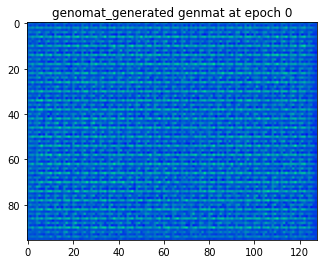

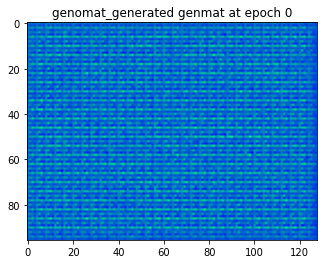

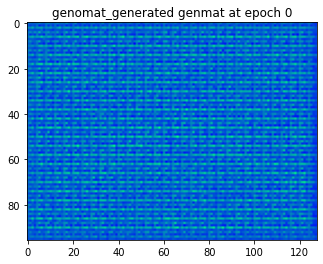

4/4 [==============================] - 26s 7s/step - d_loss: 0.6331 - g_loss: 0.6873
--- 38.50262141227722 seconds ---


In [ ]:
print('We are Ganning')
epochs= 1
gan = GAN(discriminator=build_discriminator('keras', input_shape), generator=build_generator('keras', genob.num_samples, latent_dim), latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.000005, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.discriminator.summary()
# This is necessary to fit the model eagerly. Without this I get a bunch of errors.
gan.run_eagerly=True
import time
timer = time.time()
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)])
print("--- %s seconds ---" % (time.time() - timer))

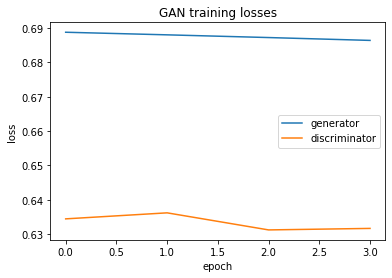

In [ ]:
gan.plot_training()

In [ ]:
!rm -r /content/results/D*

rm: cannot remove '/content/results/D*': No such file or directory
